# Plasmids MILP experiment 4

## Description

The following describes the experiment with iterative Plasmids assembly MILP with additional constraints to remove cycles. The plasmids obtained in this experiment have exactly one component each and the component is a path. This has been achieved by adding two types of constraints:
1. The number of contigs in the plasmid should be exactly one more than the number of links in the plasmid.
2. However, the first constraint can also be satisfied by graphs with multiple component containing exactly 1 path and the rest as cycles. Hence, we add constraints to remove any cyclic sequence of contigs in the plasmid. The resulting plasmid will contain exactly one path. 
As the number of cycles generated can be exponential, we add the second type of constraints iteratively as we identify a cyclic sequence. So, for instance, for a plasmid $p$, let $\{a,b,c,d\}$ be contigs involved in a cycle and $\{a_hb_h,b_tc_t,c_hd_t,d_ha_t\}$ be the links in the cycle, we add exactly one constraint:

links[$p$][$a_hb_h$] + links[$p$][$a_hb_h$] + links[$p$][$a_hb_h$] + links[$p$][$a_hb_h$] $\leq$ 3

If the number of such constraints is greater than 50 (which seems to happen frequently), the linearization is performed greedily removing the least weighted link in each remaining cycle. 

NOTE: Just to stress on the motivation behind the two types of constraints: <br>
We are looking for exactly one plasmid in one iteration of the MILP. After obtaining the plasmid, the assembly graph is updated by reducing the read depths of relevant contigs. The MILP is then run again using the updated graph till a stopping condition has been reached. Each plasmid is expected to be a single component - either a path or a cycle. In other words, the collection of contigs that constitute the plasmid form either a path or a cycle. However, there is a possibility that the plasmid obtained contains multiple components, exactly one of which is a path and the rest are cycles. This satisfies type 1 constraints above. Since we want the plasmids to contain exactly one component, we need to get rid of all cycles. Thus, the final solution will contain exactly one path and no cycles satisfying the one component requirement. An example of the process has been shown in Figure 1 below. For brevity, $p(e) = 1$ if link $e$ is present in the plasmid. 

In addition to these constraints, we also separate questionable plasmids away from putative plasmids. The conditions under which a plasmid is classified as putative are as follows:

1. min_gene_density[plasmid] $\geq$ 0.3
2. min_gene_density[seed_contig] $\geq$ 1.5$*$min_gene_density[plasmid] $=$ 0.45
3. 1500 $\leq$ min_length[plasmid] $\leq$ 1750000

In [27]:
from IPython.display import Image
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

#### Figure 1: Linearization to obtain single component

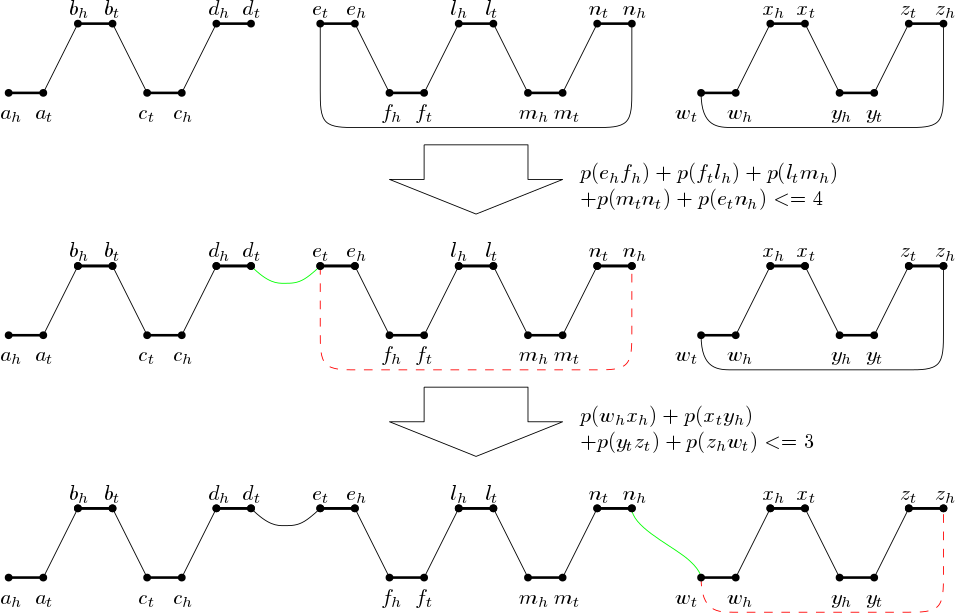

In [31]:
Image(filename="linearization.png", width=600)

In [2]:
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.switch_backend('agg')
%matplotlib inline

In [3]:
output_dir = '../output'
greedy_dir = '../../../../Plasmids-Assembly/exp/2018-07-20__sample_analyses_greedy_strategy/greedy_v2'

In [4]:
def update_dict(line, stat_dict, file, folder_loc):
    stat = line.split(" ")[-1]
    stat_dict[file.split('/')[folder_loc]].append(float(stat))
    return stat_dict

In [39]:
def compute_mean(mean, k, precs, recs, f1s):
    mean[k] = {}
    mean[k]['precision'] = sum(precs[k])/len(precs[k])
    mean[k]['recall'] = sum(recs[k])/len(recs[k])
    mean[k]['f1_score'] = sum(f1s[k])/len(f1s[k])
    return mean

In [32]:
def compute_max(best, k, precs, recs, f1s):
    best[k] = {}
    best[k]['precision'] = max(precs[k])
    best[k]['recall'] = max(recs[k])
    best[k]['f1_score'] = max(f1s[k])
    return best

## Statistics for different samples

In this part, we use the different $\alpha$ ratios as in the previous experiment (which performed better than others). The ratios chosen for this part are 1.1.1, 1.5.1 and 1.10.1. For each ratio, the MILP was run with nplasmids  $=1$. In other words, although we remove one plasmid at a time in this experiment, the MILP has provisions to remove $k>$1 plasmids in one iteration, provided convergence is reached. The main motivation behind the iterative plasmid generation approach is to help in reaching convergence by reducing the number of variables.

A set of 9 ids was chosen to test the general performance of the MILP. These were the same ids as in the previous experiments.

The results for the 10 chosen sample ids have been compared with the results of the greedy heuristic by Robert. The results of the greedy heuristic can be found at '/Plasmids-Assembly/exp/2018-07-20__sample_analyses_greedy_strategy/greedy_v2'.

In [7]:
files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(output_dir) for f in filenames if "eval.csv" in f]
precs, recs, f1s = defaultdict(list), defaultdict(list), defaultdict(list)
prec_ratio, rec_ratio, f1_ratio = defaultdict(list), defaultdict(list), defaultdict(list)

for file in files:
    if 'sample' in file.split('/')[2]:
        sample_id = file.split('/')[2].split('_')[1]
        ratio = file.split('/')[3]
        with open(file, 'r') as f:
            for line in f:
                if "precision" in line:
                    precs = update_dict(line, precs, file, 2)
                    prec_ratio = update_dict(line, prec_ratio, file, 3)
                if "recall" in line:
                    recs = update_dict(line, recs, file, 2)
                    rec_ratio = update_dict(line, rec_ratio, file, 3)
                if "f1" in line:
                    f1s = update_dict(line, f1s, file, 2)
                    f1_ratio = update_dict(line, f1_ratio, file, 3)

In [8]:
mean, best = {}, {}
mean_scores, best_scores = [], [] 
for sample_id in precs:
    mean[sample_id] = {}
    mean[sample_id]['precision'] = sum(precs[sample_id])/len(precs[sample_id])
    mean[sample_id]['recall'] = sum(recs[sample_id])/len(recs[sample_id])
    mean[sample_id]['f1_score'] = sum(f1s[sample_id])/len(f1s[sample_id])
    mean_scores.append([sample_id, mean[sample_id]['precision'], mean[sample_id]['recall'], mean[sample_id]['f1_score']])

    best[sample_id] = {}
    best[sample_id]['precision'] = max(precs[sample_id])
    best[sample_id]['recall'] = max(recs[sample_id])
    best[sample_id]['f1_score'] = max(f1s[sample_id])  
    best_scores.append([sample_id, best[sample_id]['precision'], best[sample_id]['recall'], best[sample_id]['f1_score']])

mean_scores = pd.DataFrame(mean_scores)
mean_scores.rename(columns = {0: 'Sample', 1: 'Precision', 2: 'Recall', 3: 'F1 score'}, inplace = True)

best_scores = pd.DataFrame(best_scores)
best_scores.rename(columns = {0: 'Sample', 1: 'Precision', 2: 'Recall', 3: 'F1 score'}, inplace = True)

#### Table 1: Average scores for each sample

In [9]:
mean_scores

,Sample,Precision,Recall,F1 score
0,sample_56,0.385473,0.281593,0.304412
1,sample_125,0.997339,0.679988,0.808642
2,sample_66,0.589401,0.176610,0.260101
3,sample_103,0.579870,0.871786,0.696467
4,sample_39,0.477055,0.544619,0.505720
5,sample_109,0.392894,0.375719,0.384104
6,sample_117,0.516266,0.553348,0.533881
7,sample_11,0.456841,0.711937,0.554332
8,sample_23,0.005562,0.036668,0.009576


#### Table 2: Maximum scores for each sample

In [10]:
best_scores

,Sample,Precision,Recall,F1 score
0,sample_56,0.463750,0.365968,0.315790
1,sample_125,1.000000,0.681724,0.810744
2,sample_66,0.790371,0.213075,0.299297
3,sample_103,0.583352,0.881796,0.702179
4,sample_39,0.517681,0.584509,0.547440
5,sample_109,0.398847,0.375719,0.386938
6,sample_117,0.541724,0.559786,0.550607
7,sample_11,0.663679,0.965211,0.786536
8,sample_23,0.006623,0.036668,0.011220


In [11]:
ids = mean_scores['Sample'].values.tolist()
greedy_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(greedy_dir) for f in filenames if "greedy_mean.csv" in f]
greedy_precs, greedy_recs, greedy_f1s = defaultdict(list), defaultdict(list), defaultdict(list)

count = {}
for file in greedy_files:
    if file.split('/')[9] in ids:
        with open(file, 'r') as f:
            rl, pl, fl = [], [], []
            for line in f:
                if "score_ref_coverage" in line:
                    rl.append(line)
                if "score_pred_coverage" in line:
                    pl.append(line)
                if "overall_score" in line:
                    fl.append(line)       
            greedy_recs = update_dict(rl[0], greedy_recs, file, 9)
            greedy_precs = update_dict(pl[0], greedy_precs, file, 9)
            greedy_f1s = update_dict(fl[0], greedy_f1s, file, 9)

In [12]:
greedy_mean = {}
greedy_mean_scores = [] 
for sample_id in greedy_precs:
    greedy_mean[sample_id] = {}
    greedy_mean[sample_id]['precision'] = sum(greedy_precs[sample_id])/len(greedy_precs[sample_id])
    greedy_mean[sample_id]['recall'] = sum(greedy_recs[sample_id])/len(greedy_recs[sample_id])
    greedy_mean[sample_id]['f1_score'] = sum(greedy_f1s[sample_id])/len(greedy_f1s[sample_id])
    greedy_mean_scores.append([sample_id, greedy_mean[sample_id]['precision'], greedy_mean[sample_id]['recall'], greedy_mean[sample_id]['f1_score']])

greedy_mean_scores = pd.DataFrame(greedy_mean_scores)
greedy_mean_scores.rename(columns = {0: 'Sample', 1: 'Precision', 2: 'Recall', 3: 'F1 score'}, inplace = True)

#### Table 3:Mean scores using greedy heuristic

In [13]:
greedy_mean_scores

,Sample,Precision,Recall,F1 score
0,sample_56,1.000000,0.976956,0.988478
1,sample_125,1.000000,0.996320,0.998160
2,sample_66,1.000000,1.000000,1.000000
3,sample_103,0.580096,0.900643,0.740370
4,sample_39,0.908497,0.915360,0.911929
5,sample_109,1.000000,0.983308,0.991655
6,sample_117,0.999994,0.989847,0.994921
7,sample_11,0.862581,0.954005,0.908293
8,sample_23,0.609916,1.000000,0.804958


#### Figure 2: Average precision

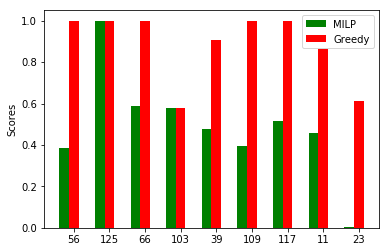

In [38]:
N = 9
ind = np.arange(N)
width = 0.27

fig = plt.figure()
axp = fig.add_subplot(111)

ids = mean_scores['Sample'].values.tolist()
ids = [k.split('_')[1] for k in ids]

pvals = mean_scores['Precision'].values.tolist()
rects1 = axp.bar(ind, pvals, width, color='g')
gpvals = greedy_mean_scores['Precision'].values.tolist()
rects2 = axp.bar(ind+width, gpvals, width, color='r')

#axp.set_title('Figure 1: Average precision')
axp.set_ylabel('Scores')
axp.set_xticks(ind+width)
axp.set_xticklabels( (ids[0], ids[1], ids[2], ids[3], ids[4], ids[5], ids[6], ids[7], ids[8]) )
axp.legend( (rects1[0], rects2[0]), ('MILP', 'Greedy') )

plt.show()

From Figures 2,3 and 4, it is clear that the greedy strategy consistently outperforms the MILP strategy once again. However, surprisingly, the performance has dipped from the last experiment. Whereas the average precision is the same as the greedy heuristic for a couple of samples, the recall is not very good. Once again, the plasmids are segregated into putative and questionable plasmids. The reasons for the poor performance needs to investigated. 

#### Figure 3: Average recall

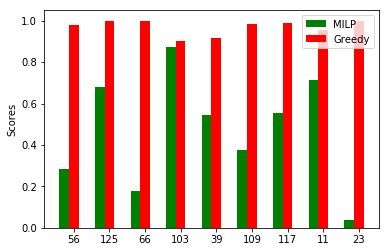

In [34]:
N = 9
ind = np.arange(N)
width = 0.27

fig = plt.figure()
axr = fig.add_subplot(111)

rvals = mean_scores['Recall'].values.tolist()
rects3 = axr.bar(ind, rvals, width, color='g')
grvals = greedy_mean_scores['Recall'].values.tolist()
rects4 = axr.bar(ind+width, grvals, width, color='r')

#axr.set_title('Figure 2: Average recall')
axr.set_ylabel('Scores')
axr.set_xticks(ind+width)
axr.set_xticklabels( (ids[0], ids[1], ids[2], ids[3], ids[4], ids[5], ids[6], ids[7], ids[8]) )
axr.legend( (rects3[0], rects4[0]), ('MILP', 'Greedy') )

plt.show()

#### Figure 4: Average F1 score

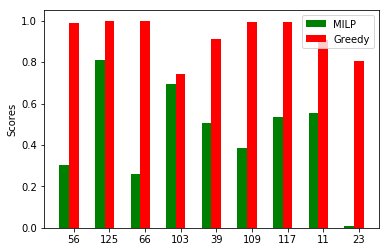

In [37]:
N = 9
ind = np.arange(N)
width = 0.27

fig = plt.figure()
axf = fig.add_subplot(111)


fvals = mean_scores['F1 score'].values.tolist()
rects5 = axf.bar(ind, fvals, width, color='g')
gfvals = greedy_mean_scores['F1 score'].values.tolist()
rects6 = axf.bar(ind+width, gfvals, width, color='r')

#axf.set_title('Figure 3: Average F1 score')
axf.set_ylabel('Scores')
axf.set_xticks(ind+width)
axf.set_xticklabels( (ids[0], ids[1], ids[2], ids[3], ids[4], ids[5], ids[6], ids[7], ids[8]) )
axf.legend( (rects5[0], rects6[0]), ('MILP', 'Greedy') )

plt.show()

#### Figure 4: Best precision, recall and F1 score

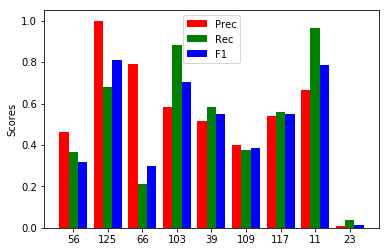

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)

pvals = best_scores['Precision'].values.tolist()
rects1 = ax.bar(ind, pvals, width, color='r')
rvals = best_scores['Recall'].values.tolist()
rects2 = ax.bar(ind+width, rvals, width, color='g')
fvals = best_scores['F1 score'].values.tolist()
rects3 = ax.bar(ind+width*2, fvals, width, color='b')
ids = best_scores['Sample'].values.tolist()
ids = [k.split('_')[1] for k in ids]
#ax.set_title('Figure 4: Best precision, recall and F1 score')
ax.set_ylabel('Scores')
ax.set_xticks(ind+width)
ax.set_xticklabels( (ids[0], ids[1], ids[2], ids[3], ids[4], ids[5], ids[6], ids[7], ids[8]) )
ax.legend( (rects1[0], rects2[0], rects3[0]), ('Prec', 'Rec', 'F1') )
plt.show()
plt.savefig(os.path.join(output_dir,'best_scores_MILP_exp-1.pdf'), format = 'pdf', dpi = 1200, bbox_inches = 'tight')

## Identifying the best ratio of coefficients in the objective function

In [22]:
ratio_mean = {}
ratio_mean_scores = [] 
for ratio in prec_ratio:
    ratio_mean[ratio] = {}
    ratio_mean[ratio]['precision'] = sum(prec_ratio[ratio])/len(prec_ratio[ratio])
    ratio_mean[ratio]['recall'] = sum(rec_ratio[ratio])/len(rec_ratio[ratio])
    ratio_mean[ratio]['f1_score'] = sum(f1_ratio[ratio])/len(f1_ratio[ratio])
    ratio_mean_scores.append([ratio, ratio_mean[ratio]['precision'], ratio_mean[ratio]['recall'], ratio_mean[ratio]['f1_score']])

ratio_mean_scores = pd.DataFrame(ratio_mean_scores)
ratio_mean_scores.rename(columns = {0: 'Ratio', 1: 'Precision', 2: 'Recall', 3: 'F1 score'}, inplace = True)

#### Table 4: Precision, recall and F1 score for various ratios

In [23]:
ratio_mean_scores

,Ratio,Precision,Recall,F1 score
0,1.10.1,0.510875,0.503135,0.485695
1,1.1.1,0.446723,0.457976,0.431035
2,1.5.1,0.509302,0.449645,0.435683


From Table 4, we can see that ratio $\alpha_1:\alpha_2:\alpha_3 = 1:10:1$ marginally outperforms the other two ratios. Thus, it is evident that more weightage to $\alpha_2$ (weighted average of gene coverage of a plasmid) consistently improves both precision and recall. It is required to figure out if there is indeed a threshold for increasing $\alpha_2$, beyond which there is no significant difference in the precision or recall.